# <font color=red>SMU DS 7331 DATA MINING - MINILAB LOGISTIC REGRESSION AND SVMS</font>

**Team Members:**
- YuMei Bennett
- Liang Huang
- Ganesh Kodi
- Eric McCandless

## <font color=blue>CREATE MODELS (50 POINTS)</font>

**Create a logistic regression model and a support vector machine model for the classification task involved with your dataset. Assess how well each model performs (use 80/20 training/testing split for your data). Adjust parameters of the models to make them more accurate. If your dataset size requires the use of stochastic gradient descent, then linear kernel only is fine to use. That is, the SGDClassifier is fine to use for optimizing logistic regression and linear support vector machines. For many problems, SGD will be required in order to train the SVM model in a reasonable timeframe.**

In [1]:
# import all necessary modules
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import Imputer
import seaborn as sns

#Read in dataset.
col_names = ['age', 'employ_type', 'pop_num', 'edu_level', 'edu_years', 'marital', 'occ', 'relation', 'race', 'gender', 'cap_gain', 'cap_loss', 'hours_week', 'country_orig', 'income']
df = pd.read_csv('adult.csv', names=col_names, header=None)

#Replace "?" with "Other_cat"
df['employ_type'] = df['employ_type'].str.replace('?','Other_cat')
df['occ'] = df['occ'].str.replace('?','Other_cat')
df['country_orig'] = df['country_orig'].str.replace('?','Other_cat')

# Binary encoding of the target variable
df['income'] = df['income'].apply(lambda inc: 0 if inc ==" <=50K" else 1) 

#Transform employ_type into multiple columns with 0 and 1
# use pd.concat to join the new columns with original dataframe then drop the original 'employ_type' column (don't need it anymore)
df = pd.concat([df,pd.get_dummies(df['employ_type'], prefix='emp')],axis=1)
df.drop(['employ_type'],axis=1, inplace=True)

#Transform gender into multiple columns with 0 and 1
# use pd.concat to join the new columns with original dataframe then drop the original 'gender' column (don't need it anymore)
df = pd.concat([df,pd.get_dummies(df['gender'], prefix='gen')],axis=1)
df.drop(['gender'],axis=1, inplace=True)

#Transform race into multiple columns with 0 and 1
# use pd.concat to join the new columns with original dataframe then drop the original 'race' column (don't need it anymore)
df = pd.concat([df,pd.get_dummies(df['race'], prefix='rac')],axis=1)
df.drop(['race'],axis=1, inplace=True)

#Transform education_level into multiple columns with 0 and 1
# use pd.concat to join the new columns with original dataframe then drop the original 'edu_level' column (don't need it anymore)
df = pd.concat([df,pd.get_dummies(df['edu_level'], prefix='edu')],axis=1)
df.drop(['edu_level'],axis=1, inplace=True)

#Consolidate education levels because many of them have the similar impact to target income.
df['edu_ SomeCollege'] = df['edu_ Some-college'] + df['edu_ Assoc-acdm'] + df['edu_ Assoc-voc'] 
df['<HS'] = df['edu_ 12th'] + df['edu_ 11th'] + df['edu_ 10th'] + df['edu_ 9th'] + df['edu_ 7th-8th'] + df['edu_ 5th-6th']+ df['edu_ 1st-4th'] + df['edu_ Preschool'] 
df=df.drop(['edu_ Some-college','edu_ Assoc-acdm','edu_ Assoc-voc', 'edu_ 12th', 'edu_ 11th','edu_ 10th','edu_ 9th','edu_ 7th-8th','edu_ 7th-8th','edu_ 5th-6th','edu_ 1st-4th','edu_ Preschool'], 1)

# drop edu_years as it is highly correlated with edu_level.
df=df.drop(['edu_years'], 1)

#Transform relation into multiple columns with 0 and 1
# use pd.concat to join the new columns with original dataframe then drop the original 'relation' column (don't need it anymore)
df = pd.concat([df,pd.get_dummies(df['relation'], prefix='rel')],axis=1)
df.drop(['relation'],axis=1, inplace=True)

#Transform marital into multiple columns with 0 and 1
# use pd.concat to join the new columns with original dataframe then drop the original 'marital' column (don't need it anymore)
df = pd.concat([df,pd.get_dummies(df['marital'], prefix='mar')],axis=1)
df.drop(['marital'],axis=1, inplace=True)

#Consolidate marital status because too many similar categories.  Married-civ-spouse and Married-AF-spouse are similar as are non-married.
df['Married'] = df['mar_ Married-civ-spouse'] + df['mar_ Married-AF-spouse'] 
df['Sep_Div_Absent_Wid'] = df['mar_ Divorced'] + df['mar_ Separated'] + df['mar_ Widowed'] + df['mar_ Married-spouse-absent']
df['Never_Married'] = df['mar_ Never-married']
df=df.drop(['mar_ Married-civ-spouse','mar_ Married-AF-spouse','mar_ Divorced', 'mar_ Separated', 'mar_ Widowed','mar_ Married-spouse-absent','mar_ Never-married'], 1)

#Transform occ into multiple columns with 0 and 1
# use pd.concat to join the new columns with original dataframe then drop the original 'occ' column (don't need it anymore)
df = pd.concat([df,pd.get_dummies(df['occ'], prefix='occu')],axis=1)
df.drop(['occ'],axis=1, inplace=True)

#Consolidate occupation by combining 'Other-service', 'Other_cat', and 'Armed-Forces. 'Other' categories are combined because they are not defined and Armed-Forces has an extremely small number of occurences.
df['occu_ Other'] = df['occu_ Other-service'] + df['occu_ Other_cat'] + df['occu_ Armed-Forces'] 
df=df.drop(['occu_ Other-service','occu_ Other_cat','occu_ Armed-Forces'], 1)

# drop pop_num as population number is an assigned index number, it has no meaning or contribution to our target income.
df=df.drop(['pop_num'], 1)

# Combine all non-U.S. native countries as only ~10% people are not from US - code native country into binary 1=United-States
df['country_orig'] = df['country_orig'].apply(lambda inc: 1 if inc ==" United-States" else 0) 

# merge capital gain and capital losscap_gain and cap_loss as it can be mathmatically concatenated into a single feature cap_gain_loss = cap_gain - cap_loss.
df['cap_gain-loss'] = df['cap_gain'] - df['cap_loss'] 
df=df.drop(['cap_gain','cap_loss'], 1)
df.head(10)

#Run logistic and supprt vetor machine model
#Use 80/20 training/testing split

,age,hours_week,country_orig,income,emp_ Federal-gov,emp_ Local-gov,emp_ Never-worked,emp_ Other_cat,emp_ Private,emp_ Self-emp-inc,...,occu_ Handlers-cleaners,occu_ Machine-op-inspct,occu_ Priv-house-serv,occu_ Prof-specialty,occu_ Protective-serv,occu_ Sales,occu_ Tech-support,occu_ Transport-moving,occu_ Other,cap_gain-loss
0,39,40,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2174
1,50,13,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,38,40,1,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
3,53,40,1,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
4,28,40,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
5,37,40,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
6,49,16,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
7,52,45,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,31,50,1,1,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,14084
9,42,40,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,5178


In [2]:
from sklearn.model_selection import ShuffleSplit

# we want to predict the X and y data as follows:
if 'income' in df:
    y = df['income'].values # get the labels we want
    del df['income'] # get rid of the class label
    X = df.values # use everything else to predict!

    ## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    #    have converted them into simple matrices to use with scikit learn
    
    
# to use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)


In [3]:
# run logistic regression and vary some parameters
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt

# first we create a reusable logisitic regression object
#   here we can setup the object with different learning parameters and constants
lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None) # get object

# now we can use the cv_object that we setup before to iterate through the 
#    different training and testing sets. Each time we will reuse the logisitic regression 
#    object, but it gets trained on different data each time we use it.

iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    # train the reusable logisitc regression model on the training data
    lr_clf.fit(X_train,y_train)  # train object
    y_hat = lr_clf.predict(X_test) # get test set precitions

    # now let's get the accuracy and confusion matrix for this iterations of training/testing
    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc )
    print("confusion matrix\n",conf)
    iter_num+=1
    
# Also note that every time you run the above code
#   it randomly creates a new training and testing set, 
#   so accuracy will be different each time

====Iteration 0  ====
accuracy 0.846307385229541
confusion matrix
 [[4612  300]
 [ 701  900]]
====Iteration 1  ====
accuracy 0.8347919545524336
confusion matrix
 [[4546  370]
 [ 706  891]]
====Iteration 2  ====
accuracy 0.8420082911100876
confusion matrix
 [[4599  357]
 [ 672  885]]


In [4]:
# interpret the weights

# iterate over the coefficients
weights = lr_clf.coef_.T # take transpose to make a column vector
variable_names = df.columns
for coef, name in zip(weights,variable_names):
    print(name, 'has weight of', coef[0])
    
# does this look correct?

age has weight of 0.027263274224677236
hours_week has weight of 0.02969121987579385
country_orig has weight of 0.2764732260299232
emp_ Federal-gov has weight of 0.24463511901756022
emp_ Local-gov has weight of -0.4119880167797364
emp_ Never-worked has weight of -0.0005637489789319069
emp_ Other_cat has weight of -0.10660296759487956
emp_ Private has weight of -0.21522495620679766
emp_ Self-emp-inc has weight of -0.052831151891663826
emp_ Self-emp-not-inc has weight of -0.7111665100291671
emp_ State-gov has weight of -0.4669731014746155
emp_ Without-pay has weight of -0.04800120557655658
gen_ Female has weight of -1.2764593928922252
gen_ Male has weight of -0.49225714662255776
rac_ Amer-Indian-Eskimo has weight of -0.39274608355175844
rac_ Asian-Pac-Islander has weight of -0.300637122657837
rac_ Black has weight of -0.44591577535466376
rac_ Other has weight of -0.3204906206594594
rac_ White has weight of -0.30892693729093385
edu_ Bachelors has weight of 0.019808049783072008
edu_ Doctora

In [5]:
# interpret the weights

# iterate over the coefficients
weights = lr_clf.coef_.T # take transpose to make a column vector
variable_names = df.columns
for coef, name in zip(weights,variable_names):
    print(name, 'has weight of', coef[0])

age has weight of 0.027263274224677236
hours_week has weight of 0.02969121987579385
country_orig has weight of 0.2764732260299232
emp_ Federal-gov has weight of 0.24463511901756022
emp_ Local-gov has weight of -0.4119880167797364
emp_ Never-worked has weight of -0.0005637489789319069
emp_ Other_cat has weight of -0.10660296759487956
emp_ Private has weight of -0.21522495620679766
emp_ Self-emp-inc has weight of -0.052831151891663826
emp_ Self-emp-not-inc has weight of -0.7111665100291671
emp_ State-gov has weight of -0.4669731014746155
emp_ Without-pay has weight of -0.04800120557655658
gen_ Female has weight of -1.2764593928922252
gen_ Male has weight of -0.49225714662255776
rac_ Amer-Indian-Eskimo has weight of -0.39274608355175844
rac_ Asian-Pac-Islander has weight of -0.300637122657837
rac_ Black has weight of -0.44591577535466376
rac_ Other has weight of -0.3204906206594594
rac_ White has weight of -0.30892693729093385
edu_ Bachelors has weight of 0.019808049783072008
edu_ Doctora

In [6]:
# sort these attributes and spit them out
zip_vars = zip(lr_clf.coef_.T,df.columns) # combine attributes
zip_vars = sorted(zip_vars)
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out

<HS has weight of -1.966152737239236
Never_Married has weight of -1.4561078457210415
rel_ Own-child has weight of -1.323167053563995
gen_ Female has weight of -1.2764593928922252
edu_ HS-grad has weight of -1.1411004395010136
occu_ Farming-fishing has weight of -1.1217184805335765
occu_ Other has weight of -0.9562289865908098
Sep_Div_Absent_Wid has weight of -0.9276960288143546
emp_ Self-emp-not-inc has weight of -0.7111665100291671
occu_ Handlers-cleaners has weight of -0.7008775492913817
edu_ SomeCollege has weight of -0.6964506187730232
rel_ Other-relative has weight of -0.545392517580287
rel_ Unmarried has weight of -0.5217153395718971
gen_ Male has weight of -0.49225714662255776
emp_ State-gov has weight of -0.4669731014746155
occu_ Machine-op-inspct has weight of -0.45484325059392516
rac_ Black has weight of -0.44591577535466376
emp_ Local-gov has weight of -0.4119880167797364
rac_ Amer-Indian-Eskimo has weight of -0.39274608355175844
rac_ Other has weight of -0.3204906206594594


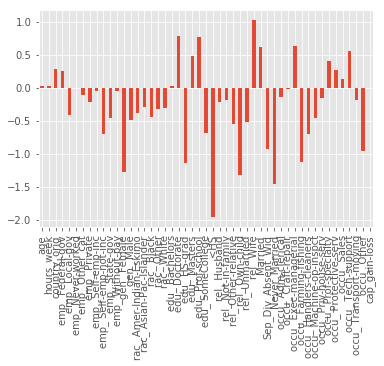

In [7]:
# now let's make a pandas Series with the names and values, and plot them
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')


weights = pd.Series(lr_clf.coef_[0],index=df.columns)
weights.plot(kind='bar')
plt.show()

In [8]:
from sklearn.preprocessing import StandardScaler
# we want to normalize the features based upon the mean and standard deviation of each column. 
# However, we do not want to accidentally use the testing data to find out the mean and std (this would be snooping)

from sklearn.pipeline import Pipeline
# you can apply the StandardScaler function inside of the cross-validation loop 
#  but this requires the use of PipeLines in scikit. 
#  A pipeline can apply feature pre-processing and data fitting in one compact notation
#  Here is an example!

std_scl = StandardScaler()
lr_clf = LogisticRegression(penalty='l2', C=0.05) 

# create the pipline
piped_object = Pipeline([('scale', std_scl),  # do this
                         ('logit_model', lr_clf)]) # and then do this

weights = []
# run the pipline cross validated
for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
    piped_object.fit(X[train_indices],y[train_indices])  # train object
    # it is a little odd getting trained objects from a  pipeline:
    weights.append(piped_object.named_steps['logit_model'].coef_[0])
    

weights = np.array(weights)

C:\Users\lhuang\AppData\Local\Continuum\anaconda37\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\lhuang\AppData\Local\Continuum\anaconda37\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\lhuang\AppData\Local\Continuum\anaconda37\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\lhuang\AppData\Local\Continuum\anaconda37\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\lhuang\AppData\Local\Contin

In [9]:
# okay, so run through the cross validation loop and set the training and testing variable for one single iteration
for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
X_train_scaled = std_scl.transform(X_train) # apply to training##scl_obj
X_test_scaled = std_scl.transform(X_test)##scl_obj

C:\Users\lhuang\AppData\Local\Continuum\anaconda37\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\lhuang\AppData\Local\Continuum\anaconda37\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [10]:
# lets investigate SVMs on the data and play with the parameters and kernels
from sklearn.svm import SVC

# train the model just as before
svm_clf = SVC(C=0.5, kernel='rbf', degree=3, gamma='auto') # get object
svm_clf.fit(X_train_scaled, y_train)  # train object

y_hat = svm_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf)

accuracy: 0.8479963150621833
[[4622  328]
 [ 662  901]]


In [21]:
# look at the support vectors
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )


(9554, 49)
(9554,)
[4955 4599]


#### Ganesh Updates Starts

In [23]:
# train the model just as before
svm_clf_lin = SVC(kernel='linear')# Linear Kernel
svm_clf_lin.fit(X_train_scaled, y_train)  # train object

y_hat_lin = svm_clf_lin.predict(X_test_scaled) # get test set precitions

acc_lin = mt.accuracy_score(y_test,y_hat_lin)
conf_lin = mt.confusion_matrix(y_test,y_hat_lin)
print('accuracy:', acc_lin )
print(conf_lin)

accuracy: 0.8472286196837095
[[4633  317]
 [ 678  885]]


In [29]:
# train the model just as before
svm_clf_pol = SVC(kernel='poly')# Polynomial Kernel
svm_clf_pol.fit(X_train_scaled, y_train)  # train object

y_hat_pol = svm_clf_pol.predict(X_test_scaled) # get test set precitions

acc_pol = mt.accuracy_score(y_test,y_hat_pol)
conf_pol = mt.confusion_matrix(y_test,y_hat_pol)
print('accuracy:', acc_pol )
print(conf_pol)

accuracy: 0.8429295255642562
[[4609  341]
 [ 682  881]]


## <font color=blue>MODEL ADVANTAGES (10 POINTS)</font>

**Discuss the advantages of each model for each classification task. Does one type of model offer superior performance over another in terms of prediction accuracy? In terms of training time or efficiency? Explain in detail.**

## <font color=blue>INTERPRET FEATURE IMPORTANCE (30 POINTS)</font>

**Use the weights from logistic regression to interpret the importance of different features for the classification task. Explain your interpretation in detail. Why do you think some variables are more important?**

In [ ]:
# sort these attributes and spit them out
zip_vars = zip(lr_clf.coef_.T,df.columns) # combine attributes
zip_vars = sorted(zip_vars)
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out
    
# now let's make a pandas Series with the names and values, and plot them
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')


weights = pd.Series(lr_clf.coef_[0],index=df.columns)
weights.plot(kind='bar')
plt.show()

##### Based on above weightage and bar graph analysis following features are considered to be highly importants among all other features
1. cap_gain-loss --> composite feature of capital gain and loss is taking high precendence  with weight of 1.27. Higher capital person tends to fall into > 55K category.
2. Married status of Marital feature --> With weight of 0.44, Married person tends to earn more 
3. Age --> Age with weight of  0.36, is also another feature which determines the income level 
4. Education level  '<HS'  --> With negative weight of 0.37, education level lesser than high school adversely affecting the income of individual

## <font color=blue>INTERPRET SUPPORT VECTORS (10 POINTS)</font>

**Look at the chosen support vectors for the classification task. Do these provide any insight into the data? Explain. If you used stochastic gradient descent (and therefore did not explicitly solve for support vectors), try subsampling your data to train the SVC model— then analyze the support vectors from the subsampled dataset.**

In [35]:
# Now let's do some different analysis with the SVM and look at the instances that were chosen as support vectors

# now lets look at the support for the vectors and see if we they are indicative of anything
# grabe the rows that were selected as support vectors (these are usually instances that are hard to classify)

# make a dataframe of the training data
df_tested_on = df.iloc[train_indices] # saved from above, the indices chosen for training
# now get the support vectors from the trained model
df_support = df_tested_on.iloc[svm_clf.support_,:]

df_support['ICM'] = y[svm_clf.support_] # add back in the 'Survived' Column to the pandas dataframe
df['ICM'] = y # also add it back in for the original data
df_support.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9554 entries, 31467 to 1972
Data columns (total 50 columns):
age                        9554 non-null int64
hours_week                 9554 non-null int64
country_orig               9554 non-null int64
emp_ Federal-gov           9554 non-null uint8
emp_ Local-gov             9554 non-null uint8
emp_ Never-worked          9554 non-null uint8
emp_ Other_cat             9554 non-null uint8
emp_ Private               9554 non-null uint8
emp_ Self-emp-inc          9554 non-null uint8
emp_ Self-emp-not-inc      9554 non-null uint8
emp_ State-gov             9554 non-null uint8
emp_ Without-pay           9554 non-null uint8
gen_ Female                9554 non-null uint8
gen_ Male                  9554 non-null uint8
rac_ Amer-Indian-Eskimo    9554 non-null uint8
rac_ Asian-Pac-Islander    9554 non-null uint8
rac_ Black                 9554 non-null uint8
rac_ Other                 9554 non-null uint8
rac_ White                 9554 non-null ui

C:\Users\lhuang\AppData\Local\Continuum\anaconda37\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


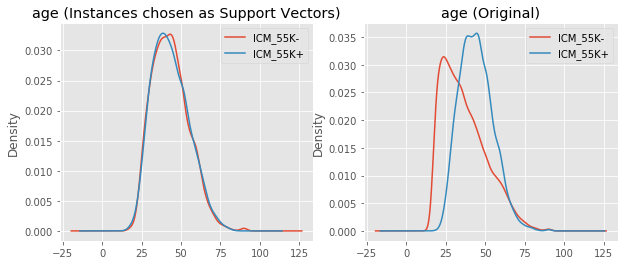

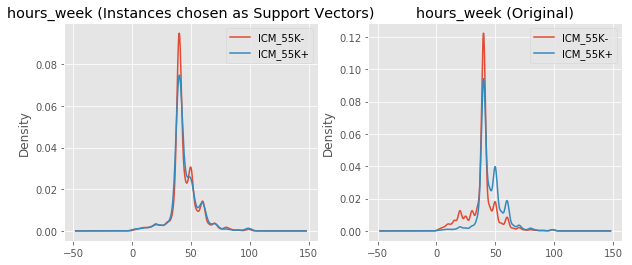

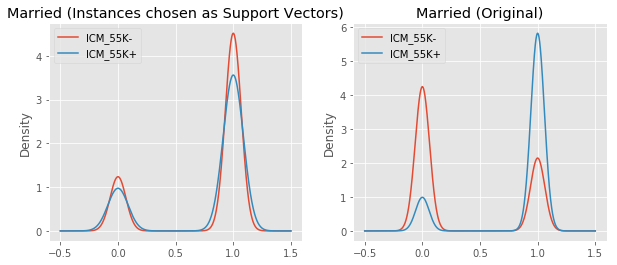

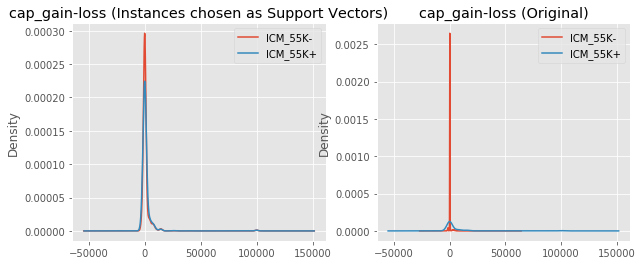

In [38]:
# now lets see the statistics of these attributes
#from pandas.tools.plotting import boxplot
from pandas.plotting import boxplot

# group the original data and the support vectors
df_grouped_support = df_support.groupby(['ICM'])
df_grouped = df.groupby(['ICM'])

# plot KDE of Different variables
vars_to_plot = ['age','hours_week','Married','cap_gain-loss']

for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['ICM_55K-','ICM_55K+'])
    plt.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['ICM_55K-','ICM_55K+'])
    plt.title(v+' (Original)')

So the analysis here is basically telling us what the original statistics of the data looked like, and also what the statistics of the support vectors looked like. We can see that the separation in distributions is not as great as the separation for the original data. This is because the support vectors tend to be instances on the edge of the class boundaries and also instances that are classified incorrectly in the training data.